In [1]:
from torch.utils.data import Dataset, DataLoader
import PIL.Image as Image
import os
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
import random
import torch.nn.functional as F
from tqdm import tqdm

/home/yuchi/anaconda3/envs/torch230/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8780 2195
10975
torch.Size([3, 224, 224])
torch.Size([224, 224])
(224, 224, 3)
(224, 224)


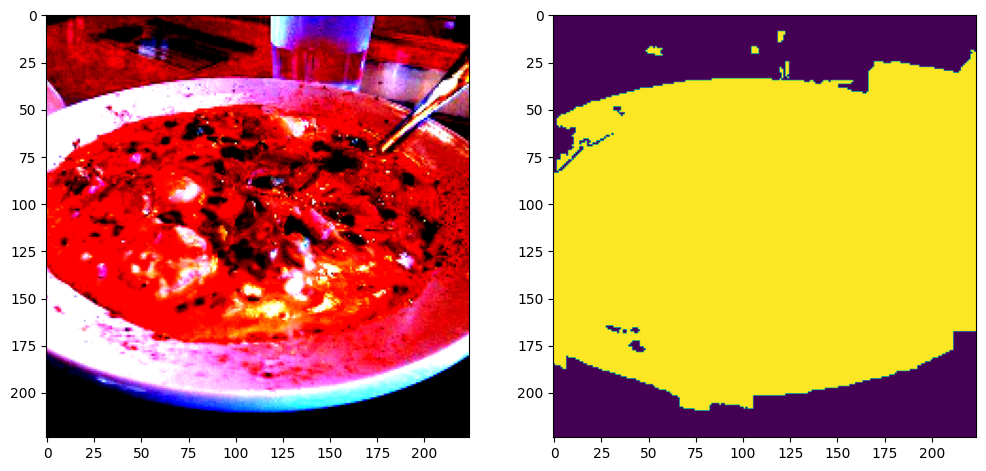

In [2]:
def make_dataset(root1, root2):
    imgs = []
    lst = []
    for filename in os.listdir(root1):
        img = os.path.join(root1, filename)
        mask = os.path.join(root2, filename.replace('jpg', 'png'))
        imgs.append((img, mask))
    return imgs
def get_labels():
    return np.asarray([[0, 0, 0], [1,1,1],])
def encode_segmap(mask):
    mask = mask.astype(int)
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
    for ii, label in enumerate(get_labels()):
        label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
    label_mask = label_mask.astype(int)
    return label_mask

class TrafficDataset(Dataset):
    def __init__(self, root1, root2, transform=None):
        imgs = make_dataset(root1, root2)
        self.imgs = imgs
        self.transform = transform


    def __getitem__(self, index):
        x_path, y_path = self.imgs[index]
        img = Image.open(x_path)
        mask = Image.open(y_path)
        img = np.array(img)
        mask = np.array(mask)
        if mask.ndim == 3:
            mask = mask[:, :, 2]  # 取出藍色通道作為標籤
        #mask = mask[:,:,2] #get label dim
        mask = np.where(mask>=1, 1,0)
        if self.transform is not None:
            #transformed = transform(image=img, mask=mask)
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']

        return img, mask

    def __len__(self):
        return len(self.imgs)
    

batch_size = 8
w, h = (224, 224)
transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Normalize(),
    ToTensorV2(),
])

train_img_path = '/home/yuchi/AI/food/trainingimages'
train_mask_path = '/home/yuchi/AI/food/traininglabels'

trainset = TrafficDataset(train_img_path, train_mask_path, transform=transform)
valsize = int(len(trainset)*0.2)
trainsize = len(trainset) - valsize
print(trainsize, valsize)
train_set, val_set = torch.utils.data.random_split(trainset, [trainsize, valsize])

l = len(trainset)
print(l)
img, mask = trainset[random.randint(0, l)]
print(img.shape)
print(mask.shape)
img = img.permute(1,2,0).numpy()
mask = mask.numpy()

print(img.shape)
print(mask.shape)

fig = plt.figure(figsize=(12, 12))
fig.add_subplot(1, 2, 1)
plt.imshow(img)
fig.add_subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

batch_size = 8
w, h = (128, 128)
transform = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Normalize(),
    ToTensorV2(),
])

train_img_path = '/home/yuchi/AI/food/trainingimages'
train_mask_path = '/home/yuchi/AI/food/traininglabels'

trainset = TrafficDataset(train_img_path, train_mask_path, transform=transform)
valsize = int(len(trainset)*0.2)
trainsize = len(trainset) - valsize
train_set, val_set = torch.utils.data.random_split(trainset, [trainsize, valsize])

train_dataloaders = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloaders = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=4)


In [3]:
#---------------------------------------------------------------------------------------------------------------------------------------------

In [4]:
import torch
import torch.nn as nn

# Define ResNet block
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += residual
        out = self.relu(out)
        return out

# Define UNet model
class Unet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Unet, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.block1 = ResNetBlock(64, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.block2 = ResNetBlock(128, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.block3 = ResNetBlock(256, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.block4 = ResNetBlock(512, 512)

        # Decoder
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(512, 256, kernel_size=3, padding=1)  # Match concatenated channels

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(256, 128, kernel_size=3, padding=1)  # Match concatenated channels

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(128, 64, kernel_size=3, padding=1)   # Match concatenated channels

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)  # Output layer

    def forward(self, x):
        # Encoder
        x1 = self.conv1(x)
        x1 = self.block1(x1)
        x2 = self.pool1(x1)
        x2 = self.conv2(x2)
        x2 = self.block2(x2)
        x3 = self.pool2(x2)
        x3 = self.conv3(x3)
        x3 = self.block3(x3)
        x4 = self.pool3(x3)
        x4 = self.conv4(x4)
        x4 = self.block4(x4)

        # Decoder
        x = self.upconv3(x4)
        x = torch.cat((x, x3), dim=1)  # Concatenate with encoder output
        x = self.conv5(x)

        x = self.upconv2(x)
        x = torch.cat((x, x2), dim=1)
        x = self.conv6(x)

        x = self.upconv1(x)
        x = torch.cat((x, x1), dim=1)
        x = self.conv7(x)

        x = self.final_conv(x)
        return x

# Initialize weights
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight)

in_channels = 3
out_channels = 1
model = Unet(in_channels, out_channels)
model.apply(init_weights)


Unet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block1): ResNetBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block2): ResNetBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block3): ResNetBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(

In [5]:
num_epochs = 1
batch_size = 4
device = torch.device("cpu")
in_channel, out_channel = 3, 1
model = Unet(in_channel, out_channel).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0008)
# Binary Cross Entropy Loss (適合二元分割)
criterion = nn.BCEWithLogitsLoss()  # 使用 logit 的 BCE 適合在最後一層未加 sigmoid 的情況
best_val_loss = float('inf')  # 初始化最佳驗證損失為無限大

# 训练循环
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss = 0.0
    for images, masks in train_dataloaders:
        images, masks = images.to(device), masks.to(device)
        #masks = masks.to(device=device, dtype=torch.long)  # Ensure masks are LongTensor
        masks = masks.unsqueeze(1)
        masks = masks.float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
 
        total_loss += loss.item()

    if total_loss < best_val_loss:
        best_val_loss = total_loss
        torch.save(model.state_dict(), '/home/yuchi/AI/best_model.pth')
        print(f"Model saved with validation loss: {total_loss:.4f}")

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_dataloaders)}")


Epoch 1/1
Model saved with validation loss: 541.5685
Epoch 1/1, Loss: 0.49323182358984957


In [6]:
#---------------------------------------------------------------------------------------------------------------------------------------------

In [7]:
test_img_path = '/home/yuchi/AI/food/testimages'
test_mask_path = '/home/yuchi/AI/food/testlabels'
model_path = "/home/yuchi/AI/best_model.pth"

# 初始化模型並載入權重
in_channel, out_channel = 3, 1
model = Unet(in_channel, out_channel).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
w, h = (128, 128)
transform = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Normalize(),
    ToTensorV2(),
],is_check_shapes=False)

# 遍歷每張測試影像並生成掩碼
threshold = 0.5
# 遍歷每張測試影像並生成二值化掩碼
with torch.no_grad():
    for img_name in tqdm(os.listdir(test_img_path), desc="Generating masks"):
        # 讀取並處理影像
        img_path = os.path.join(test_img_path, img_name)
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)  # 將 PIL 圖像轉為 numpy 格式
        
        # 應用轉換
        transformed = transform(image=image)
        image = transformed["image"].unsqueeze(0).to(device)  # 增加批次維度
        
        # 預測掩碼
        output = model(image)
        pred = torch.sigmoid(output).squeeze().cpu().numpy()  # 使用 Sigmoid 激活並移除多餘的維度
        pred = (pred > threshold).astype(np.uint8) * 255  # 閾值化為 0 和 255，轉為二值掩碼

        # 保存二值化掩碼
        mask = Image.fromarray(pred)  # 轉為 PIL 格式
        mask_name = img_name.replace('.jpg', '.png')  # 修改檔名為掩碼格式
        mask.save(os.path.join(test_mask_path, mask_name))

print("所有測試掩碼已成功生成並儲存至:", test_mask_path)

Generating masks: 100%|██████████| 1636/1636 [03:17<00:00,  8.27it/s]

所有測試掩碼已成功生成並儲存至: /home/yuchi/AI/food/testlabels


In [8]:
test_img_path = '/home/yuchi/AI/food/testimages'
test_mask_path = '/home/yuchi/AI/food/testlabels'
model_path = "/home/yuchi/AI/best_model.pth"

w, h = (128, 128)
transform = A.Compose([
    A.Resize(height=128, width=128),
    A.Normalize(),
],is_check_shapes=False)

testset = TrafficDataset(test_img_path, test_mask_path, transform=transform)
bs = batch_size
test_dataloaders = DataLoader(testset, batch_size=bs, shuffle=False, num_workers=4)

device = torch.device('cpu')
in_channel, out_channel = 3, 1
model = Unet(in_channel, out_channel).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

epoch_loss=0
gt = np.empty([0, 1, 128, 128])
result = np.empty([0, 1, 128, 128])
criterion = nn.BCEWithLogitsLoss()
pbar = tqdm(total = len(test_dataloaders)+1, ncols=150)
c = 0
epoch_loss=0
for x, y in test_dataloaders:
    inputs = x.permute(0, 3, 1, 2).to(device).float()
    labels = y.to(device).float().unsqueeze(dim=1)
    outputs = model(inputs)

    loss = criterion(outputs, labels)
    epoch_loss += loss.item()

    outputs = F.sigmoid(outputs)
    result = np.concatenate((result, outputs.cpu().detach().numpy()), axis=0)
    gt = np.concatenate((gt, labels.cpu().detach().numpy()), axis=0)

    pbar.update(1)

epoch_loss /= len(test_dataloaders)
pbar.update(1)
pbar.close()
print(epoch_loss, 1-epoch_loss)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 410/410 [02:57<00:00,  2.31it/s]

0.37545727838222437 0.6245427216177757


In [9]:
print(np.unique(result[0]))
result.shape, gt.shape

def rle_encoding(x):
    dots = np.where(x.flatten()==1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths
def convert_into_rle(mask, pred_root):
    encoding = []
    for i, m in enumerate(mask[:]):
        encoding.append(rle_encoding(m))

    print(len(encoding))

    with open(pred_root, 'w', ) as csvfile:
        csvfile.write("ImageId,EncodedPixels\n")
        for i, m in enumerate(encoding):
            conv = lambda l: ' '.join(map(str, l))
            subject, img = 1, 1
            text = '{},{}'.format(i,conv(encoding[i]))+'\n'
            csvfile.write(text)

threthold = 0.5
pred = np.where(result>=threthold,1,0)
print(pred[0].shape, pred[0].dtype)
print(np.unique(pred[0]))

convert_into_rle(pred, '/home/yuchi/AI/pred_08_1.csv')

[0.00641152 0.00689651 0.0069556  ... 0.98224741 0.98278332 0.98340732]
(1, 128, 128) int64
[0 1]
1636
